In [24]:
import pandas as pd
import geopandas as gpd
pd.options.display.max_columns = 999

#import plotly
#import plotly.graph_objs as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

from mpl_toolkits.axes_grid1 import make_axes_locatable
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns



# For changes in .py
%reload_ext autoreload
%autoreload 2

import numpy as np

import missingno as msno

stats = ['skew', 'mad', 'kurt']


import qgrid

def qg(df):
    return(qgrid.show_grid(df,show_toolbar=True, grid_options={'forceFitColumns': False}))

import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', -1)
pd.set_option('display.max_colwidth', 100)

import requests
import json
import xmltodict
import re
import urllib.request as urllib2
import io
import yaml

import math
import pysal as ps

from pysal.esda.mapclassify import Quantiles, Equal_Interval, Fisher_Jenks


import warnings
warnings.filterwarnings('ignore')
import imageio

Populating the interactive namespace from numpy and matplotlib


In [2]:
maps        = gpd.read_file('../maps/sp_municipios.json',encoding='utf-8')
maps_meso = maps.dissolve(by='nome_mesorregiao', as_index=False)

In [3]:
ocorrencias = pd.read_csv('../dados/ssp_ocorrecencias_registradas.csv', encoding='utf-8')
codigo_ibge  = pd.read_csv('../dados/ssp_codigo_ibge.csv', encoding='utf-8')
populacao    = pd.read_csv('../dados/populacao_municipios_2001_to_2019.csv', encoding='utf-8')

In [4]:
#put the geocode
ocorrencias = pd.merge(codigo_ibge, ocorrencias, how='inner', on='municipio')

#put the population
cols = ['geocodigo','ano','populacao']
populacao = populacao[cols]

ocorrencias = pd.merge(populacao, ocorrencias, how='inner', on=['geocodigo','ano'])

ocorrencias_anual = ocorrencias.groupby(by=['geocodigo','ano','populacao','municipio','regiao'], as_index=False).sum()
ocorrencias_anual['ano'] = ocorrencias_anual['ano'].astype(int)

In [5]:
for col in ocorrencias_anual.columns[5:]:
    ocorrencias_anual[col] = round(ocorrencias_anual[col]/ocorrencias_anual['populacao'].astype(float) * 10000, 1)

In [6]:
ocorrencias_anual = pd.merge(ocorrencias_anual, maps[['geocodigo','nome_mesorregiao','nome_microrregiao']], on='geocodigo', how='inner')
#     df_test['dado_pop'] = df_test['dado']/df_test['populacao']

In [7]:
df_final = pd.DataFrame()
cols = ocorrencias_anual.columns[5:28]
for i in range(len(cols)) :
#     print(cols[i])
    dado_regiao = ocorrencias_anual[['nome_mesorregiao',cols[i],'ano']].groupby(by=['nome_mesorregiao','ano'], as_index=False).sum()
#     df_new = pd.merge(df_test,dado_regiao,how='inner',on=['nome_mesorregiao','ano'])
    if i==0:
        df_final = dado_regiao.copy()
    else:
        df_final = pd.merge(df_final,dado_regiao, on=['nome_mesorregiao','ano'], how='outer')

In [8]:
###put the geometry
df_final = pd.merge(df_final, maps_meso, on='nome_mesorregiao', how='outer')

df_final = gpd.GeoDataFrame(df_final)


df_final['coords'] = df_final['geometry'].apply(lambda x: x.representative_point().coords[:])
df_final['coords'] = [coords[0] for coords in df_final['coords']]

In [9]:
meso_rename = {
    'Macro Metropolitana Paulista':'Metrop. Paulista',
    'Metropolitana de São Paulo':'Metrop. de São Paulo',
    'Vale do Paraíba Paulista':'Vale do Paraíba'
}

df_final['nome_mesorregiao'] = df_final['nome_mesorregiao'].replace(meso_rename)

In [10]:
ano = 2018
var = "HOMICÍDIO DOLOSO (2)"

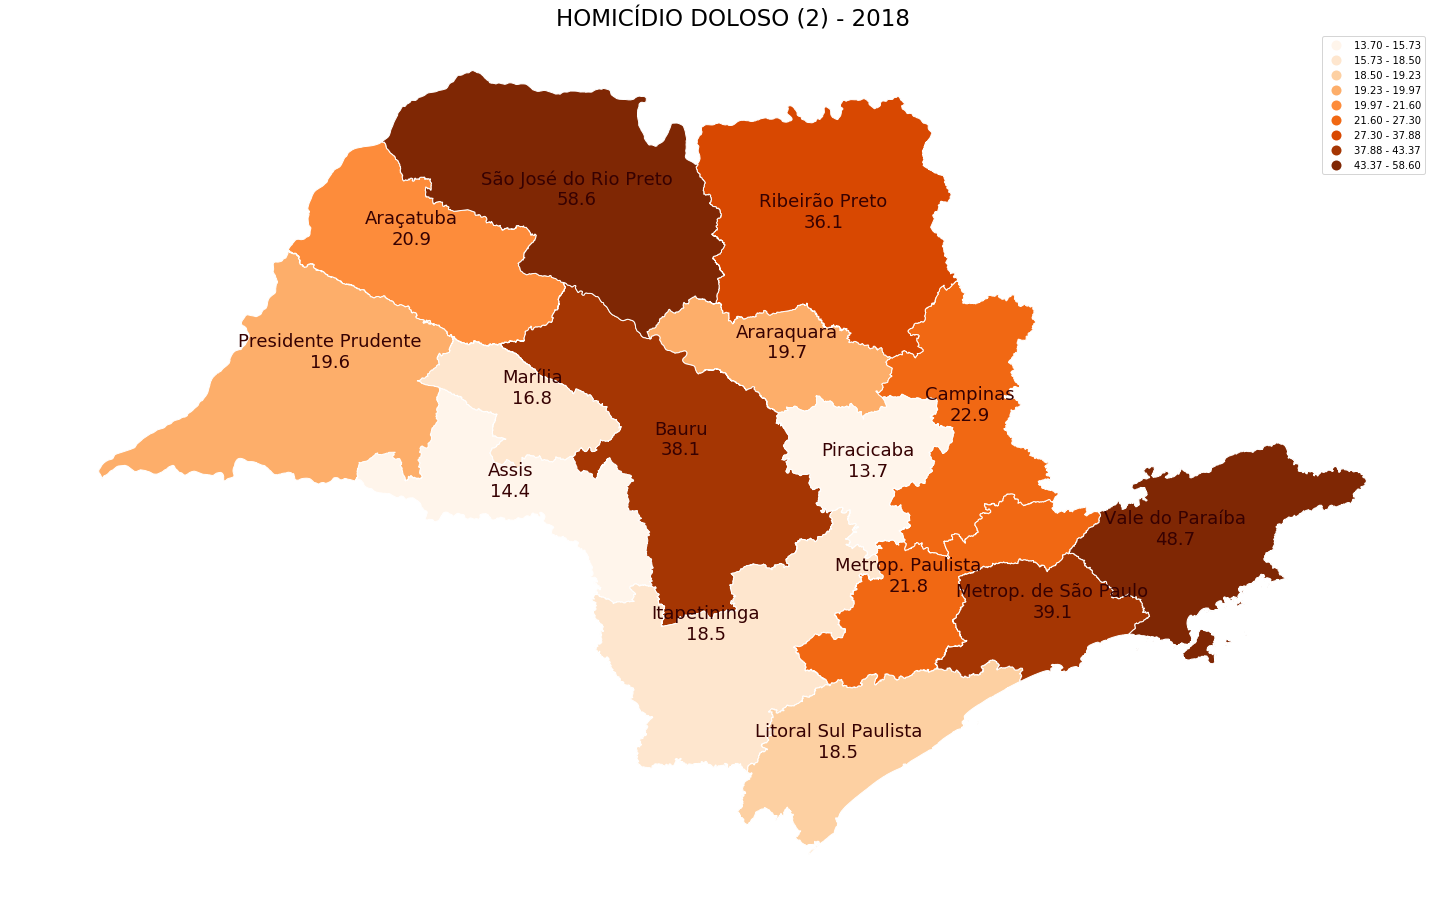

In [11]:
zmin = min(df_final[var])
zmax = max(df_final[var])

mask = df_final['ano']==ano
df_test=df_final[mask]


###--------SP--------###
fig = plt.figure(figsize=(25,25))
ax  = fig.add_subplot(1,1,1)
divider = make_axes_locatable(ax)

ax.set_title('{} - {}'.format(var,df_test['ano'].unique()[0]), fontsize=23)
mask = df_test[var].notnull()
df_test = df_test[mask]
# df_test['dado']=df_test['dado'].fillna(-1)
# df_test['dado'] = np.log(df_test['dado'])


# df_test.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[15, 18,19,20,22,35,40,45,60]}, )
df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" , scheme='quantiles',k=9)

# df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" , scheme='quantiles',k=9,  vmin=zmin, vmax=zmax)
ax.axis('off')

for idx, row in df_test.iterrows():
    plt.annotate(s=row['nome_mesorregiao'] + "\n" + str('{:.1f}'.format(row[var])), xy=row['coords'],fontsize=18,
                 horizontalalignment='center', color='#360102')


# plt.rc('legend',fontsize=15)








# fig.legend(fontsize=20)
# cax = divider.append_axes("right", size="5%", pad=0.1)
# df_test.plot(column='dado', ax=ax, legend=True,cax=cax)



# plt.legend(format='%.0e')


###--------VALE--------###

# fig = plt.figure(figsize=(20,20))
# ax  = fig.add_subplot(1,1,1)
# divider = make_axes_locatable(ax)
# ax.set_title('{} - {}'.format(var,df_test['ano'].unique()[0]), fontsize=23)
# mask = (df_test['nome_mesorregiao']=='Vale do Paraíba Paulista') 
# # & (df_test['dado'].notnull())

# df_test[mask].plot(column='dado_y', scheme='Quantiles', k=5, ax=ax, legend=True, cmap='YlGnBu')

# cax = divider.append_axes("right", size="5%", pad=0.1)
# df_test[mask].plot(column='dado', ax=ax, legend=True, cax=cax)

# plt.legend(format='%.0e')

In [57]:
def plot_map(df_final,var,ano):
    zmin = min(df_final[var])
    zmax = max(df_final[var])

    mask = df_final['ano']==ano
    df_test=df_final[mask]


    ###--------SP--------###
    fig = plt.figure(figsize=(20,20))
    ax  = fig.add_subplot(1,1,1)
    divider = make_axes_locatable(ax)
    
    ax.set_title('{} - {}'.format(var,df_test['ano'].unique()[0]), fontsize=23)
    mask = df_test[var].notnull()
    df_test = df_test[mask]
    # df_test['dado']=df_test['dado'].fillna(-1)
    # df_test['dado'] = np.log(df_test['dado'])

    

    # df_test.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[15, 18,19,20,22,35,40,45,60]}, )
    df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" , scheme='quantiles',k=9)

    # df_test.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" , scheme='quantiles',k=9,  vmin=zmin, vmax=zmax)
    ax.axis('off')
    
    
    for idx, row in df_test.iterrows():
        plt.annotate(s=row['nome_mesorregiao'] + "\n" + str('{:.1f}'.format(row[var])), xy=row['coords'],fontsize=18,
                     horizontalalignment='center', color='#360102')
    
    plt.rc('legend',fontsize=9)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    
    return(image)

In [54]:
df_final.head(0)

,nome_mesorregiao,ano,HOMICÍDIO DOLOSO (2),Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO CULPOSO OUTROS,TENTATIVA DE HOMICÍDIO,LESÃO CORPORAL SEGUIDA DE MORTE,LESÃO CORPORAL DOLOSA,LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO,LESÃO CORPORAL CULPOSA - OUTRAS,LATROCÍNIO,Nº DE VÍTIMAS EM LATROCÍNIO,TOTAL DE ESTUPRO (4),ESTUPRO,ESTUPRO DE VULNERÁVEL,TOTAL DE ROUBO - OUTROS (1),ROUBO - OUTROS,ROUBO DE VEÍCULO,ROUBO A BANCO,ROUBO DE CARGA,FURTO - OUTROS,FURTO DE VEÍCULO,geometry,uf,nome_uf,mesorregiao_geografica,microrregiao_geografica,nome_microrregiao,municipio,geocodigo,nome_municipio,latitude,longitude,nome_municip_ibge,coords


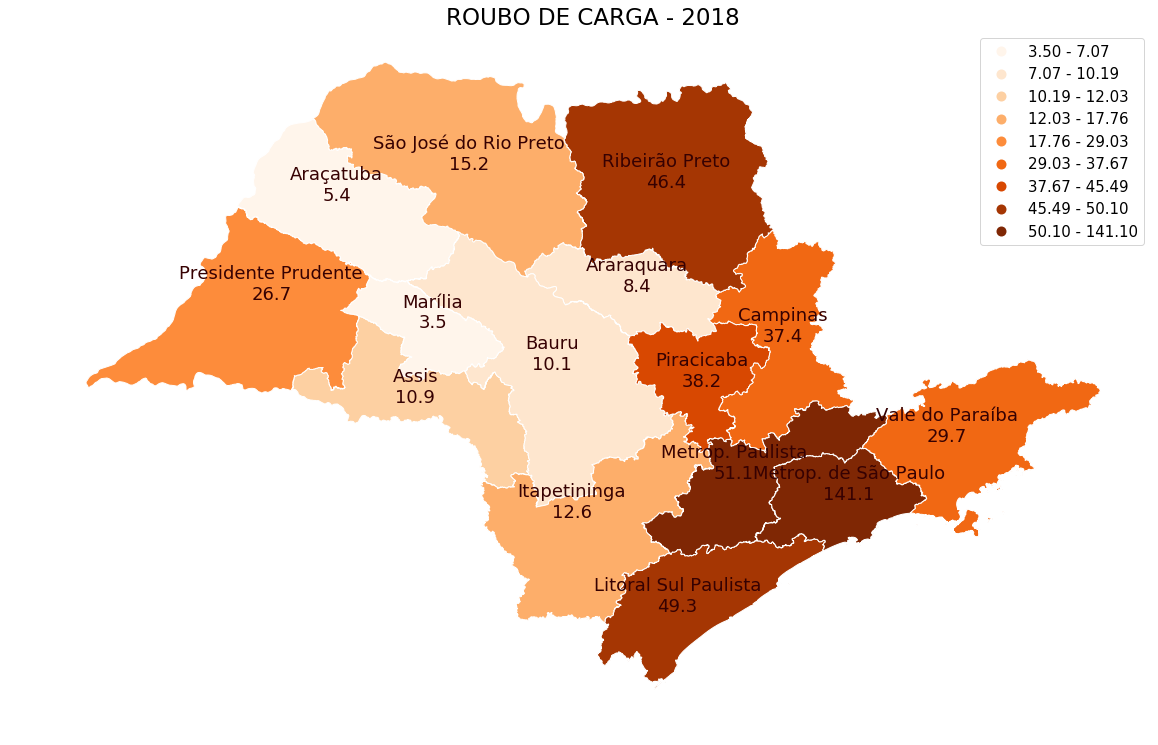

In [55]:
anos = np.sort(df_final['ano'].unique()).tolist()
var = "ROUBO DE CARGA"
for ano in anos[16:17]:
    plot_map(df_final,var,ano)
    
    


### Save Gif

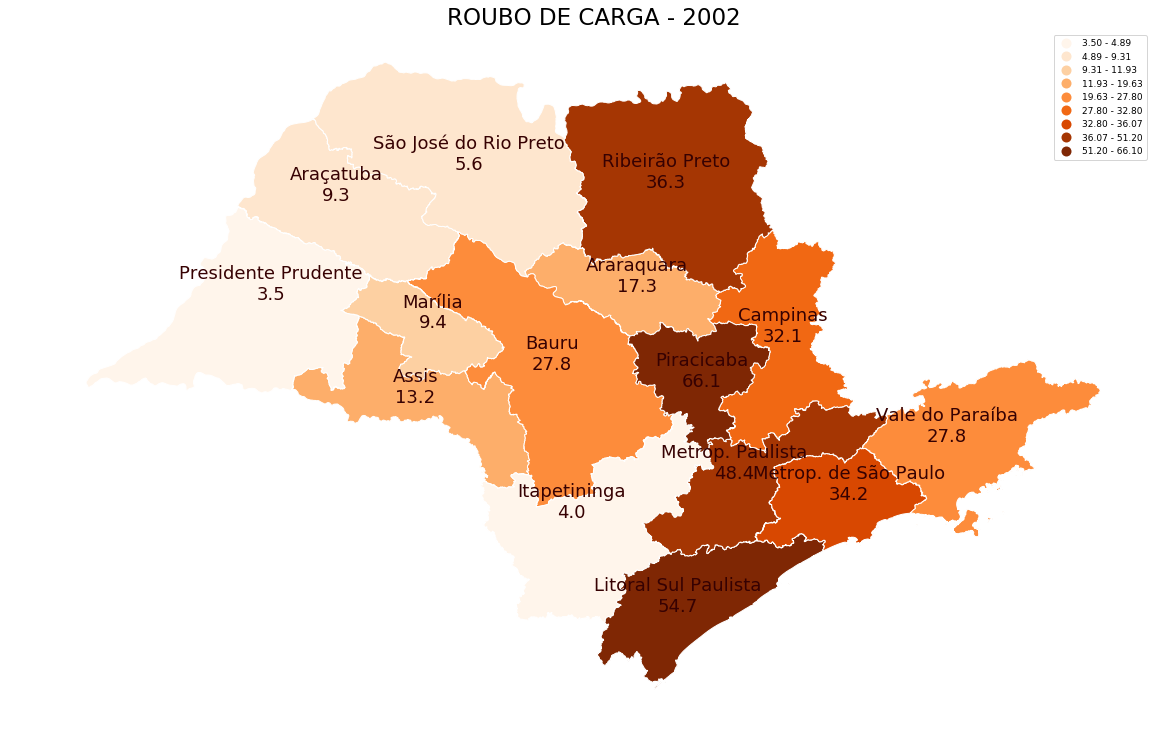

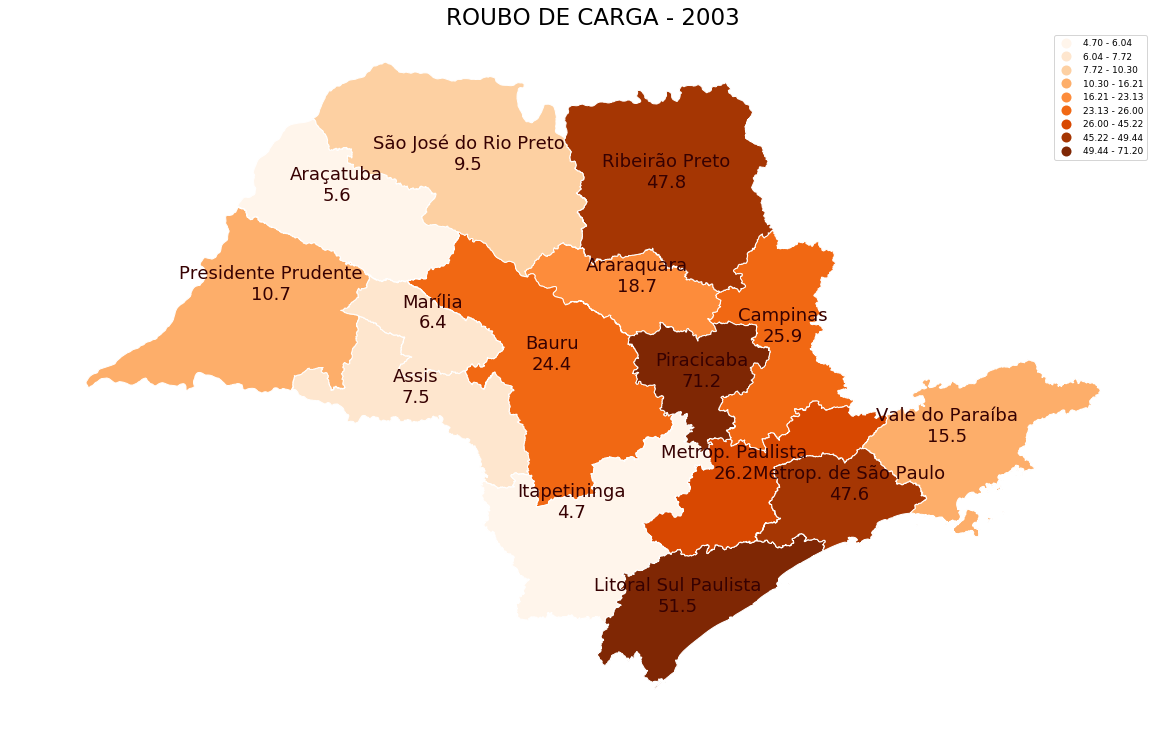

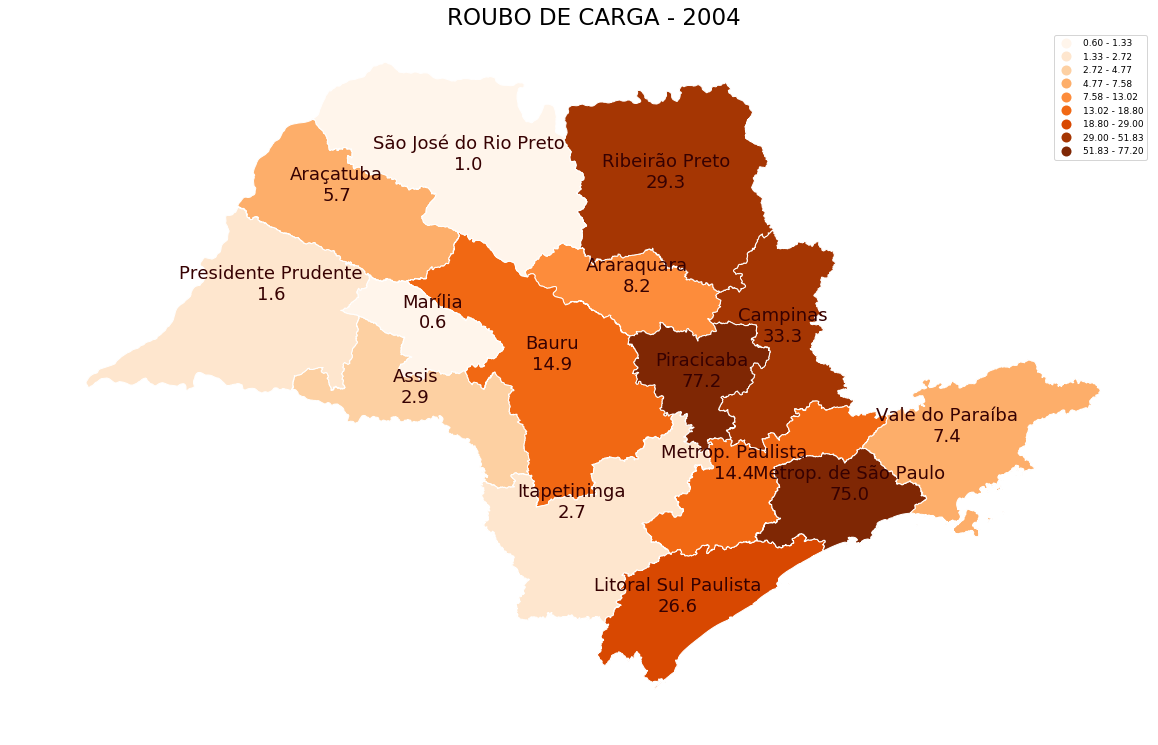

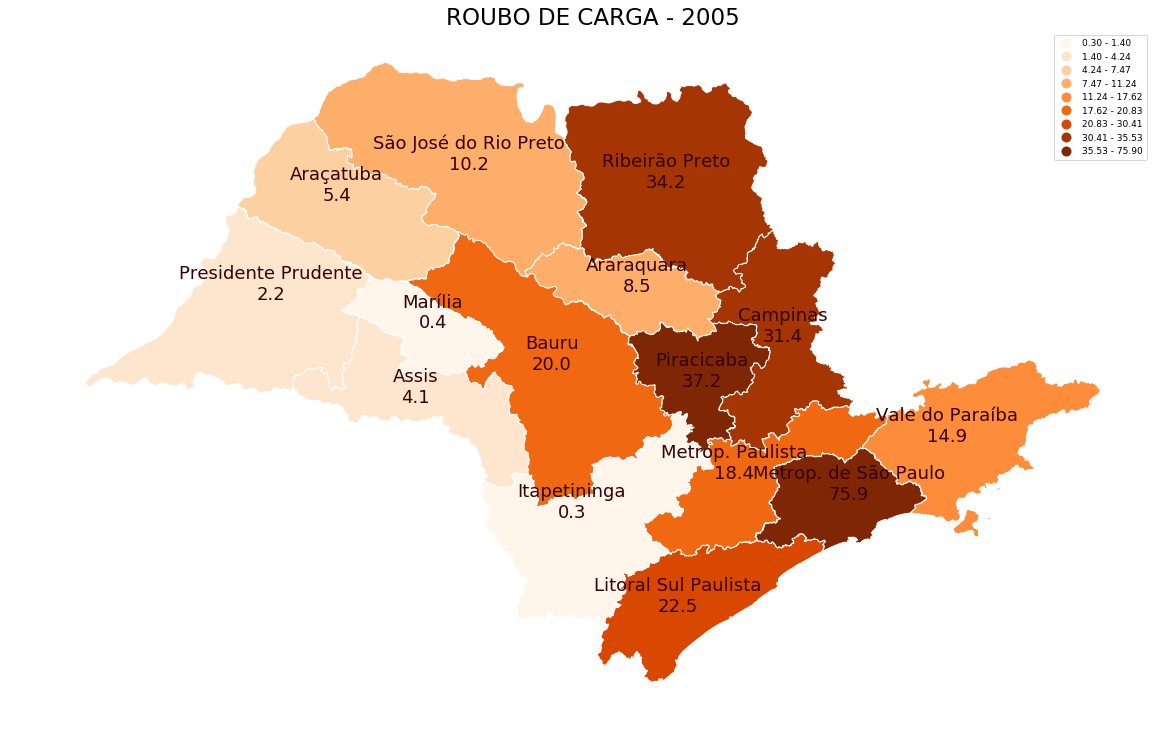

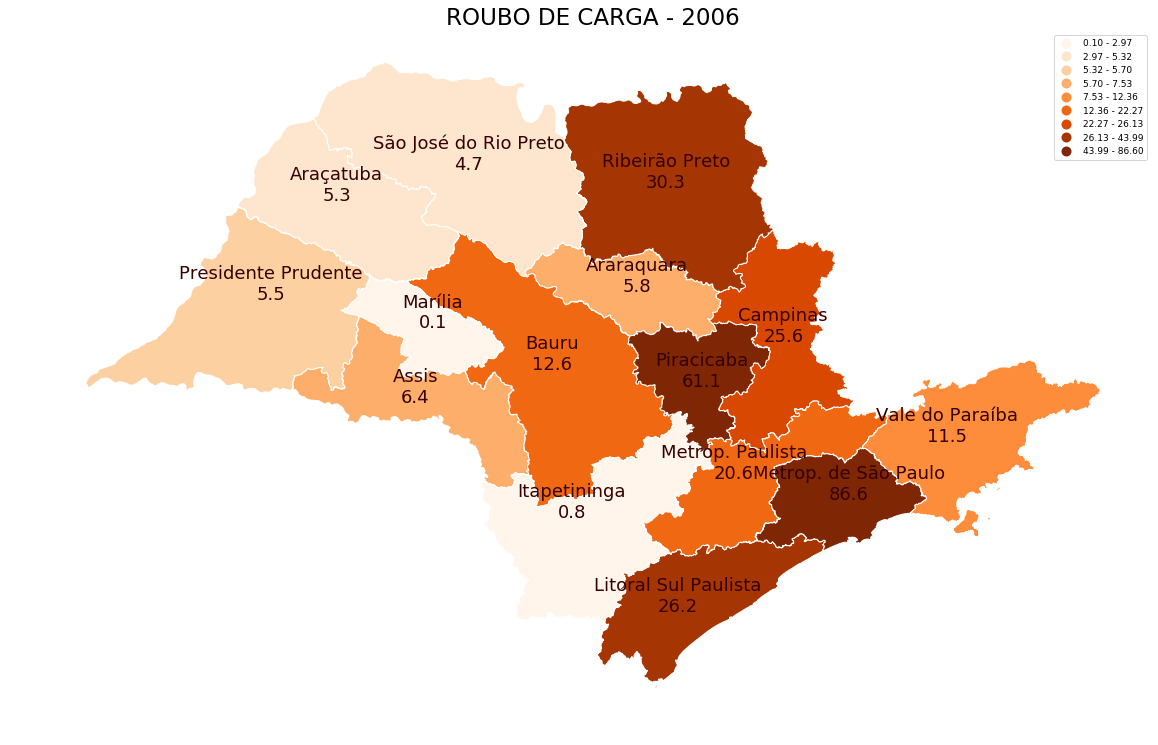

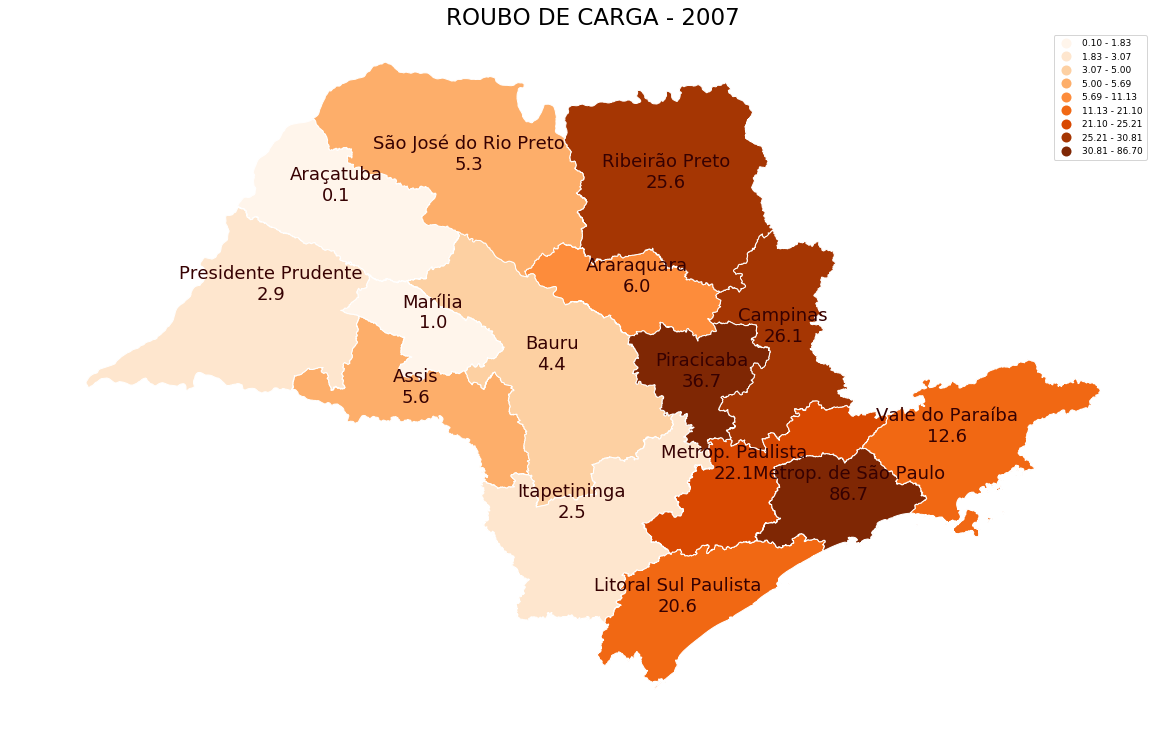

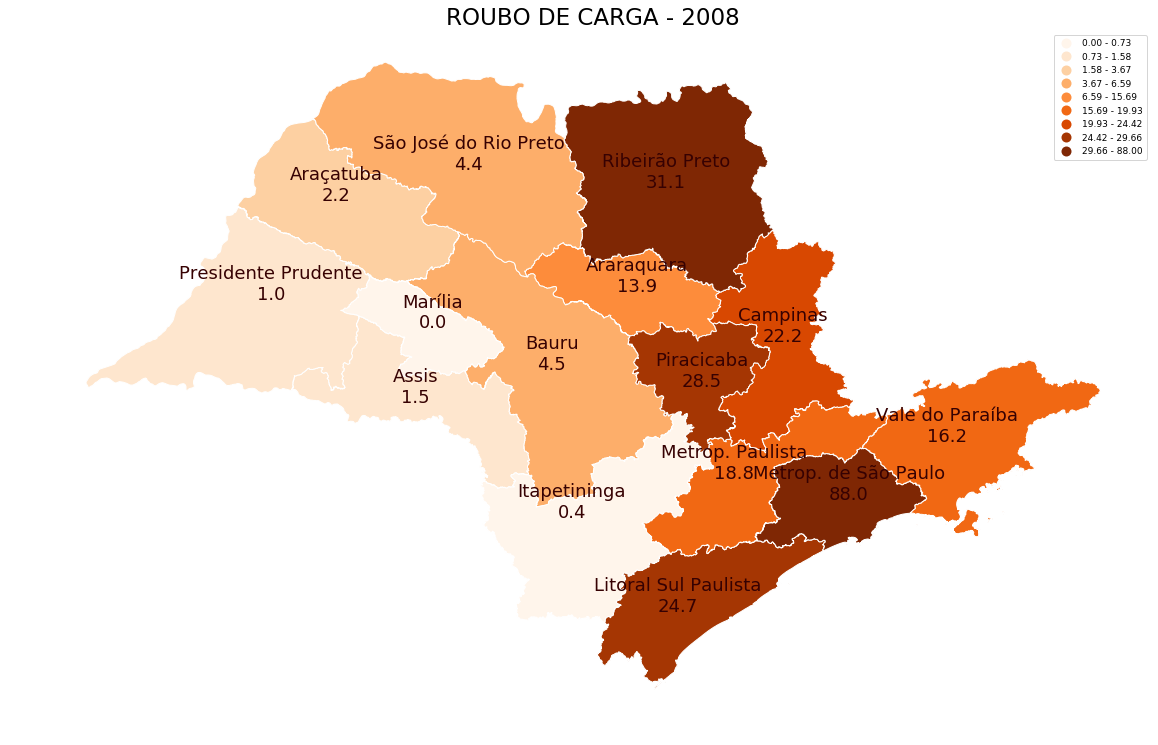

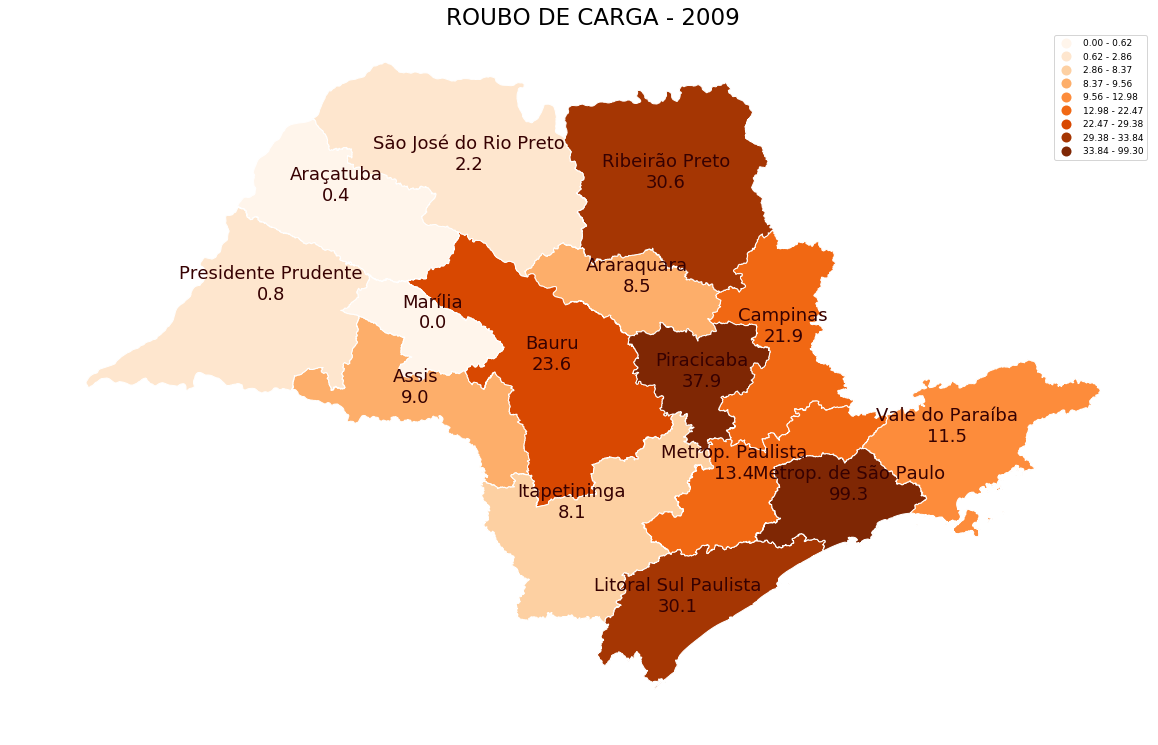

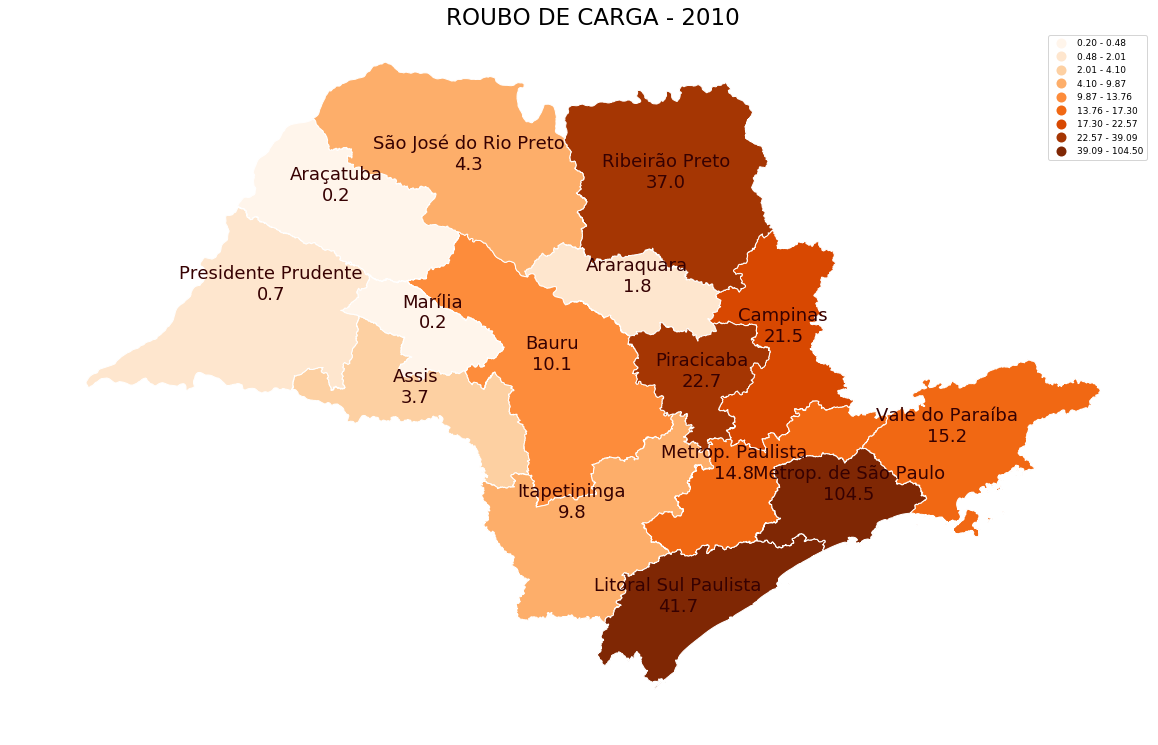

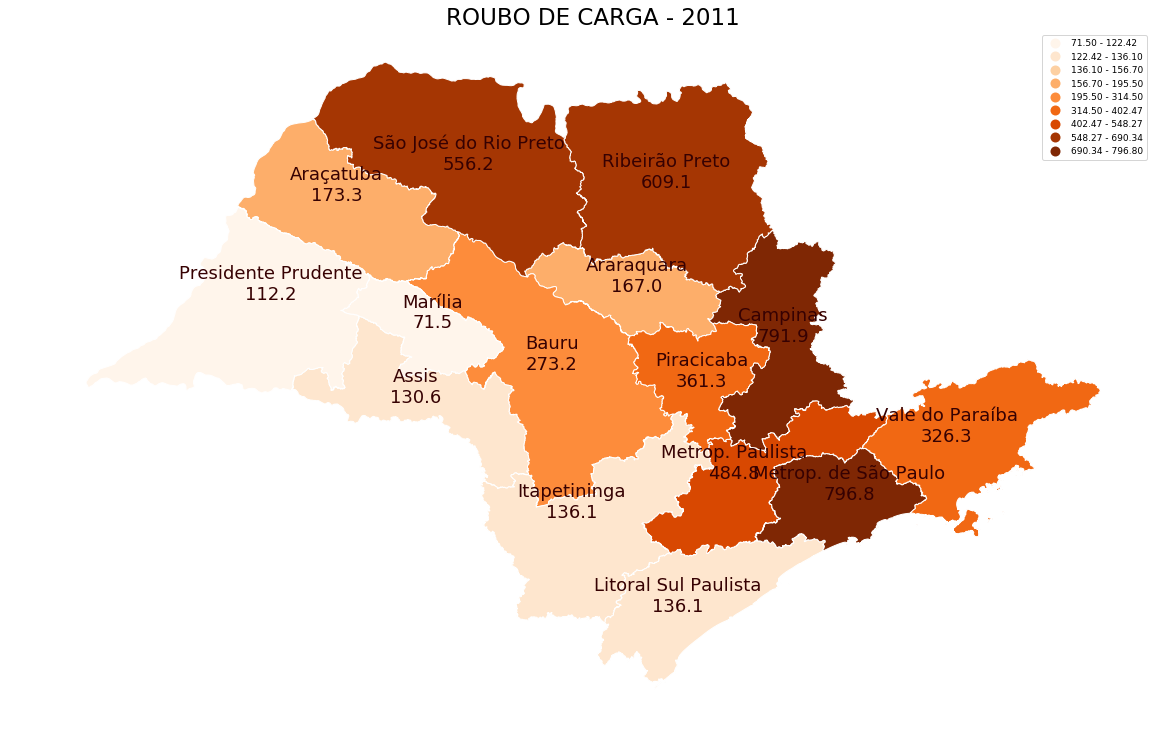

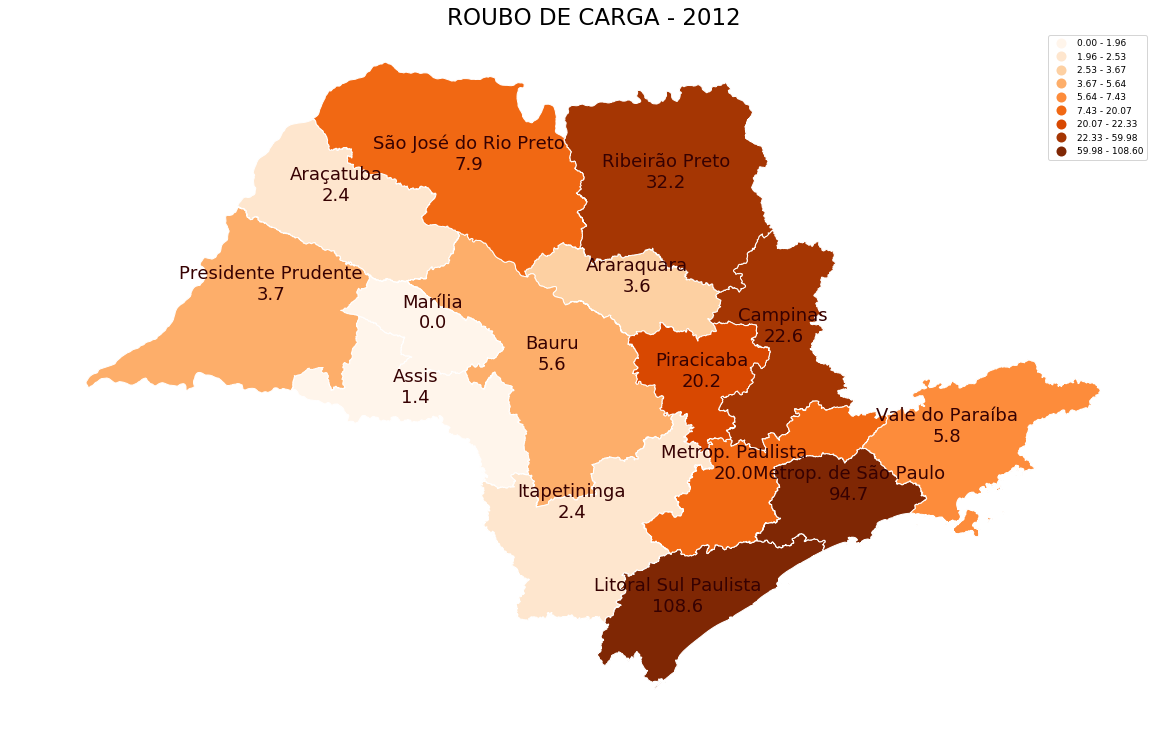

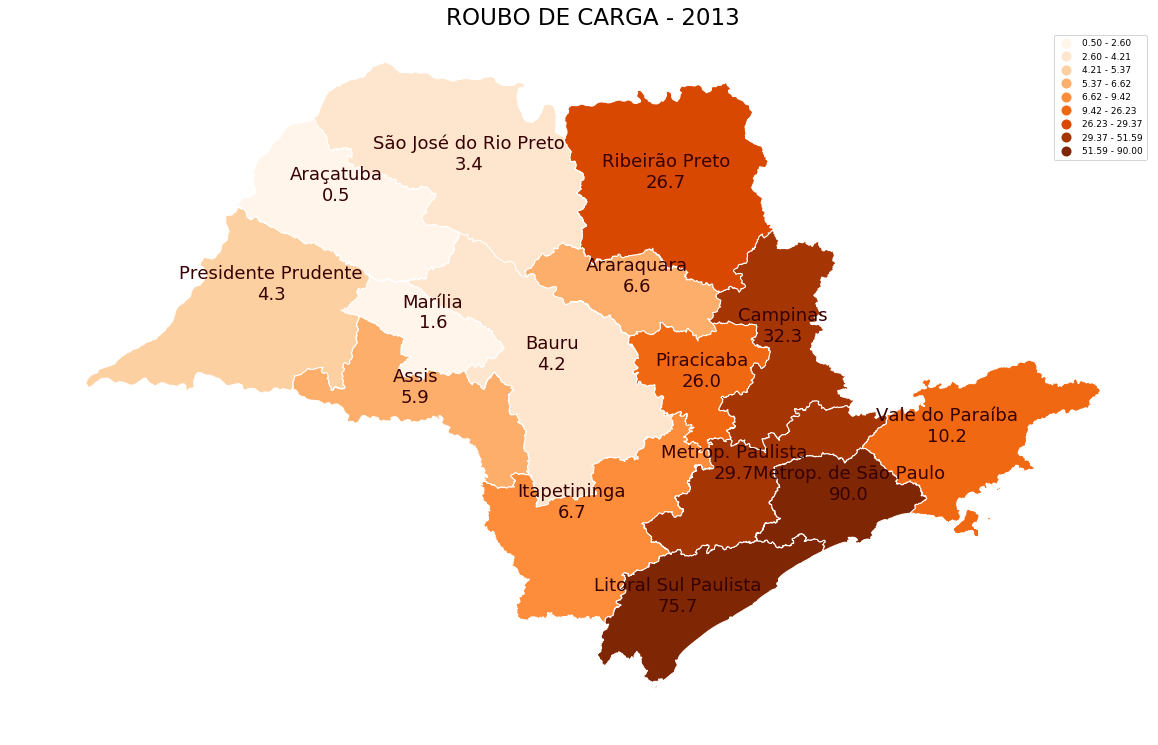

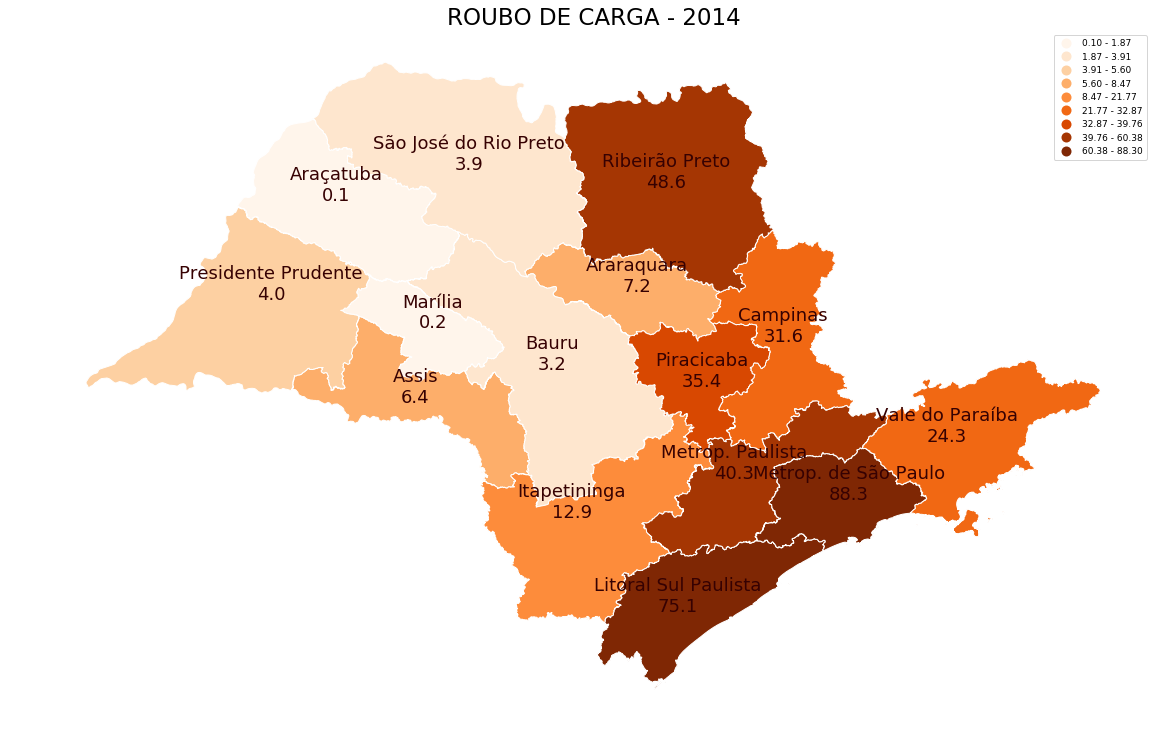

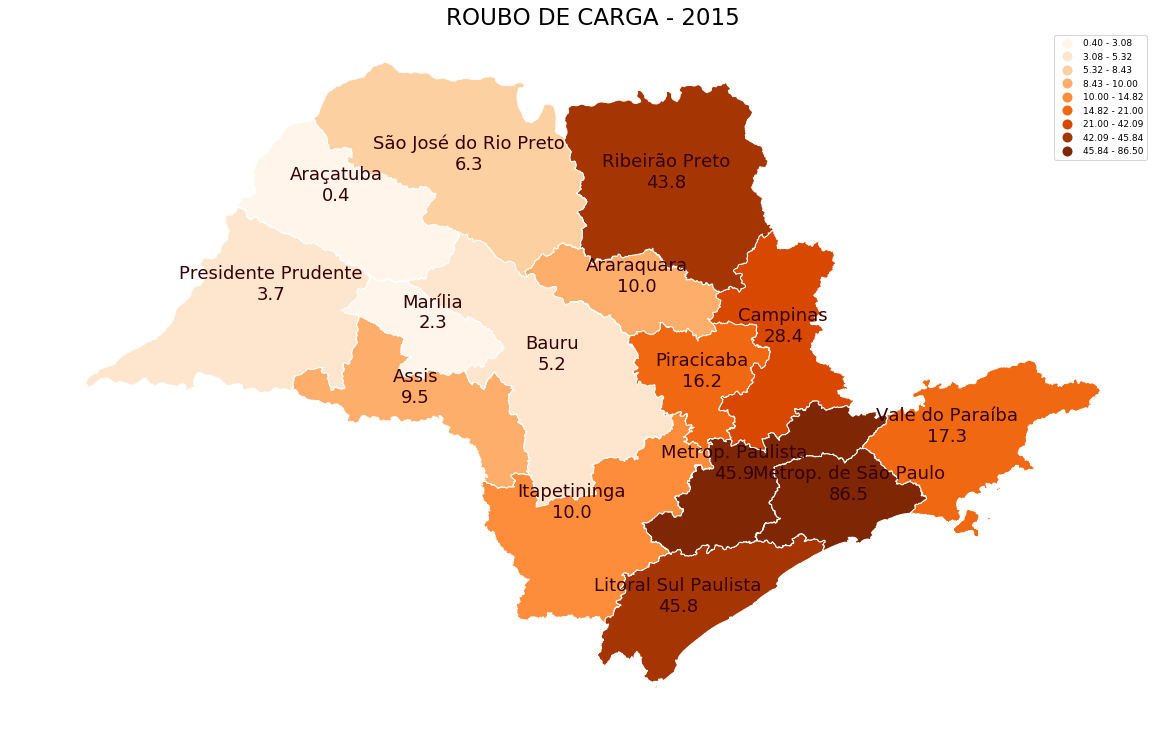

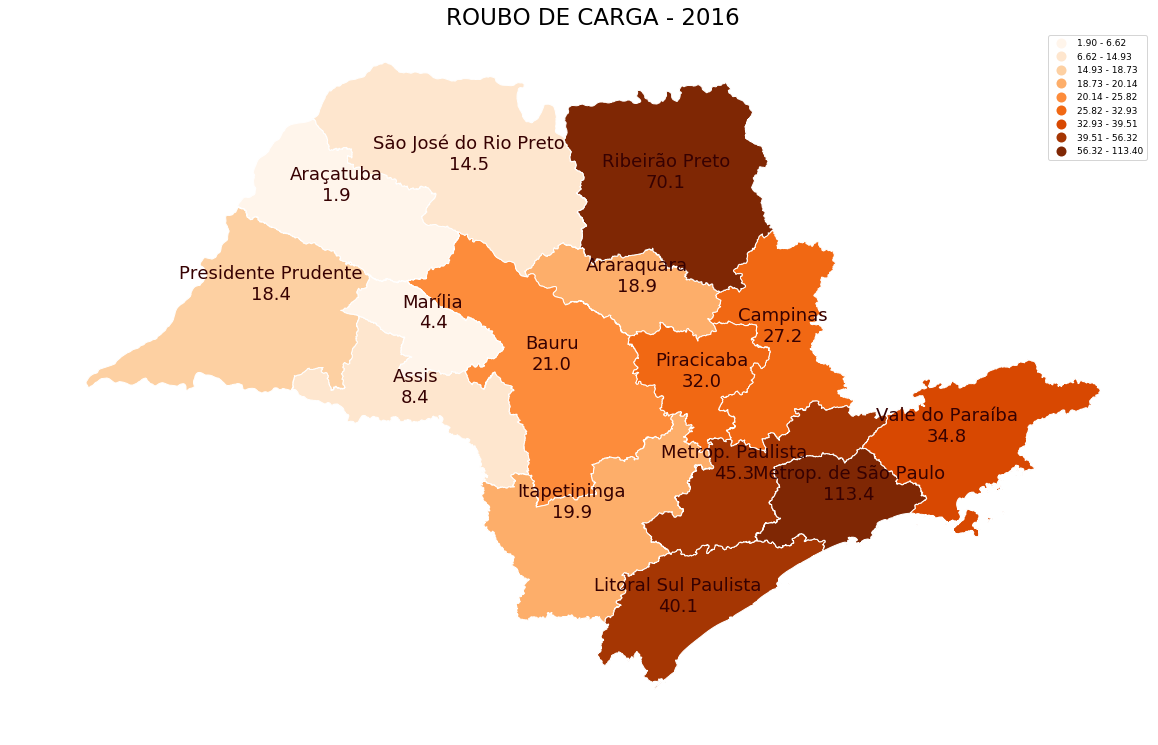

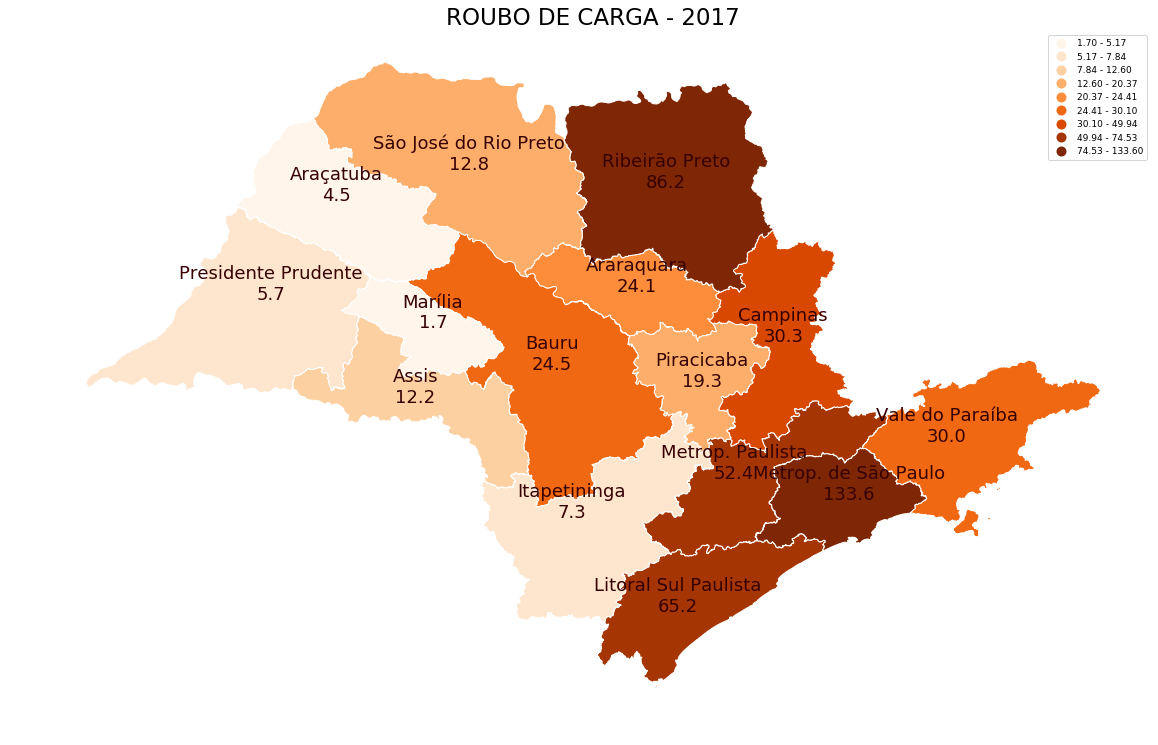

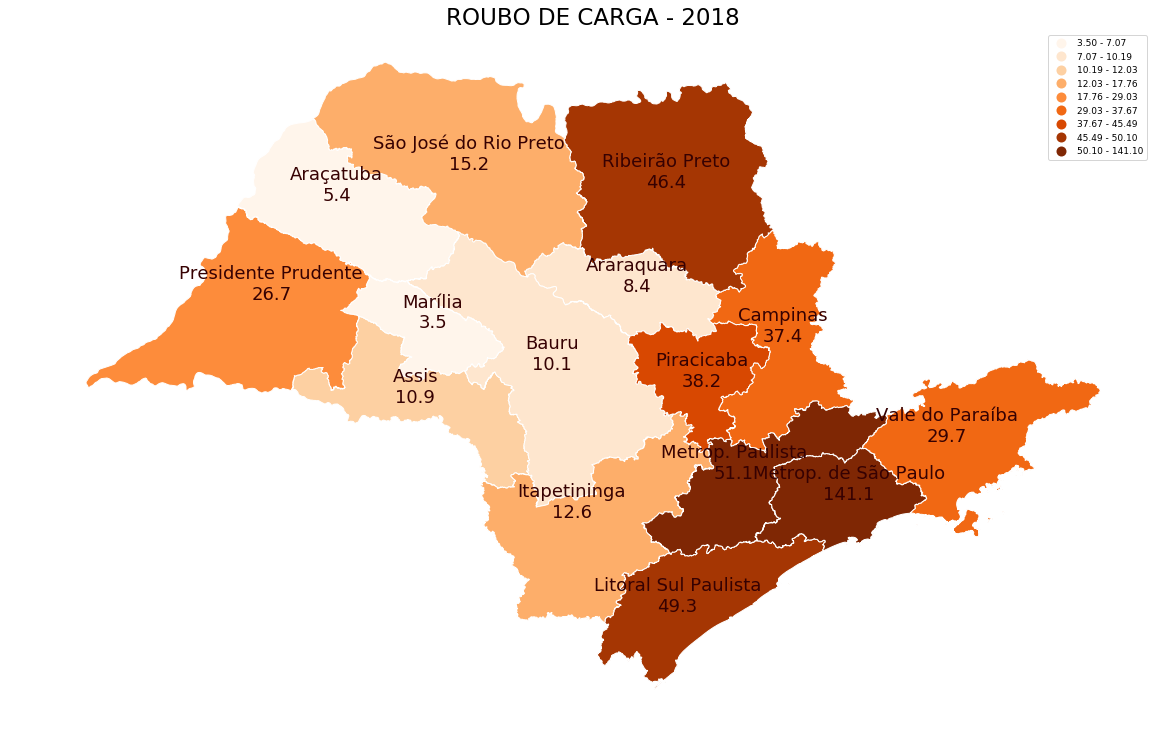

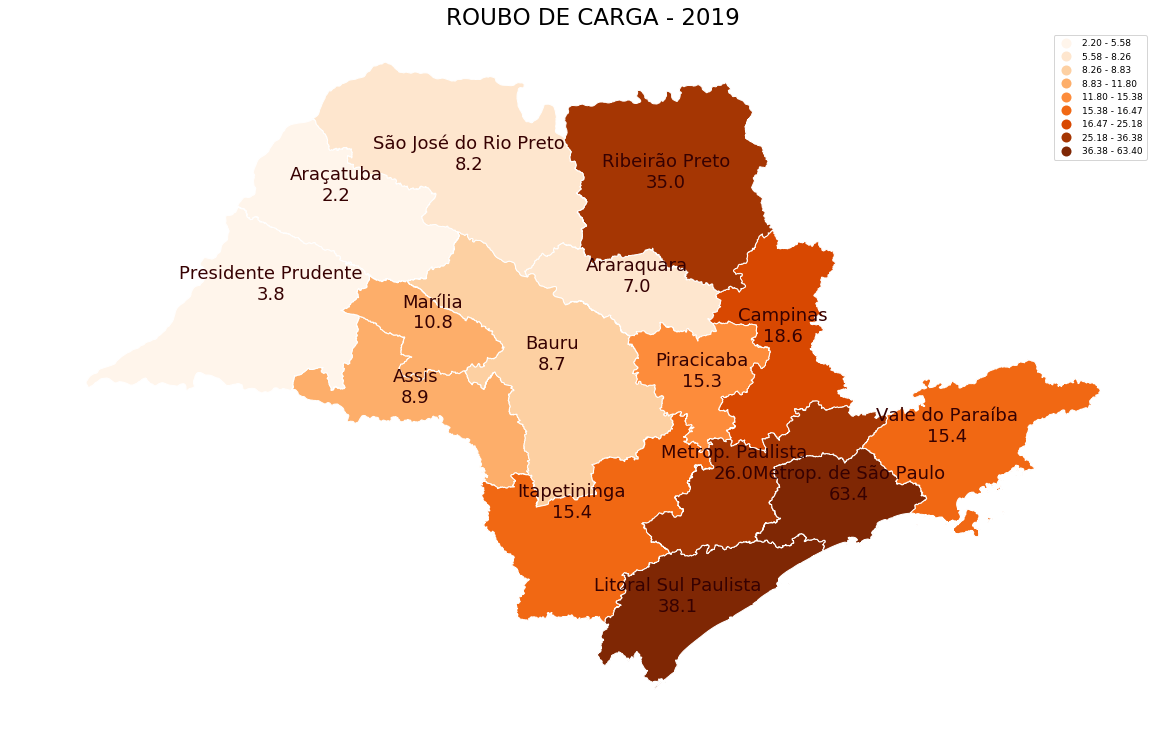

In [58]:
anos = np.sort(df_final['ano'].unique()).tolist()
var = "ROUBO DE CARGA"

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('{}.gif'.format(var), [plot_map(df_final,var,ano) for ano in anos], fps=1)